In [2]:
import os
import pandas as pd
from datasets import Dataset, DatasetDict

# 1. Clonar el repositorio oficial de GitHub
!git clone https://github.com/fmplaza/EmoEvent.git

# 2. Definir las rutas a los archivos (basado en la estructura del repo)
# Nota: Los archivos suelen estar en carpetas separadas por idioma
base_path = "EmoEvent/EmoEvent_es" # Carpeta del subset en español

# Nombres típicos de archivos en este repo (suelen ser .csv o .tsv)
train_file = os.path.join(base_path, "train.csv")
dev_file   = os.path.join(base_path, "dev.csv")
test_file  = os.path.join(base_path, "test.csv")

# 3. Función de carga robusta
def load_data(path):
    if not os.path.exists(path):
        print(f"⚠️ No encontré el archivo: {path}")
        return None
    
    # Intentamos leer. A veces usan separador de punto y coma (;) o tab (\t)
    try:
        return pd.read_csv(path)
    except:
        try:
            return pd.read_csv(path, sep='\t')
        except:
            return pd.read_csv(path, sep=';')

print("Cargando datos...")
df_train = load_data(train_file)
df_dev   = load_data(dev_file)
df_test  = load_data(test_file)

# 4. Crear el Dataset de Hugging Face
if df_train is not None:
    dataset = DatasetDict({
        "train": Dataset.from_pandas(df_train),
        "validation": Dataset.from_pandas(df_dev) if df_dev is not None else None,
        "test": Dataset.from_pandas(df_test) if df_test is not None else None
    })
    
    # Filtrar splits vacíos
    dataset = DatasetDict({k: v for k, v in dataset.items() if v is not None})

    print("\n✅ ¡Dataset cargado desde GitHub correctamente!")
    print(dataset)
    print("\nEjemplo:")
    print(dataset["train"][0])
else:
    print("\n❌ No se encontraron los archivos en la ruta esperada.")
    print("Listando archivos descargados para que los revises:")
    for root, dirs, files in os.walk("EmoEvent"):
        for file in files:
            print(os.path.join(root, file))


fatal: destination path 'EmoEvent' already exists and is not an empty directory.
Cargando datos...
⚠️ No encontré el archivo: EmoEvent/EmoEvent_es/train.csv
⚠️ No encontré el archivo: EmoEvent/EmoEvent_es/dev.csv
⚠️ No encontré el archivo: EmoEvent/EmoEvent_es/test.csv

❌ No se encontraron los archivos en la ruta esperada.
Listando archivos descargados para que los revises:
EmoEvent/emoevent_en.csv
EmoEvent/emoevent_es.csv
EmoEvent/README.md
EmoEvent/splits/.DS_Store
EmoEvent/splits/es/test.tsv
EmoEvent/splits/es/dev.tsv
EmoEvent/splits/es/train.tsv
EmoEvent/splits/en/test.tsv
EmoEvent/splits/en/dev.tsv
EmoEvent/splits/en/train.tsv
EmoEvent/splits/en/.DS_Store
EmoEvent/.git/config
EmoEvent/.git/description
EmoEvent/.git/packed-refs
EmoEvent/.git/HEAD
EmoEvent/.git/index
EmoEvent/.git/refs/remotes/origin/HEAD
EmoEvent/.git/refs/heads/master
EmoEvent/.git/hooks/prepare-commit-msg.sample
EmoEvent/.git/hooks/post-update.sample
EmoEvent/.git/hooks/applypatch-msg.sample
EmoEvent/.git/hooks/p

In [3]:
import os
import pandas as pd
from datasets import Dataset, DatasetDict

# Rutas exactas basadas en tu output
train_path = "EmoEvent/splits/es/train.tsv"
dev_path   = "EmoEvent/splits/es/dev.tsv"
test_path  = "EmoEvent/splits/es/test.tsv"

# Función para cargar TSV
def load_tsv(path):
    print(f"Cargando: {path}")
    # sep='\t' es fundamental porque son archivos .tsv
    return pd.read_csv(path, sep='\t')

# 1. Cargar DataFrames
try:
    df_train = load_tsv(train_path)
    df_dev   = load_tsv(dev_path)
    df_test  = load_tsv(test_path)

    # 2. Convertir a Dataset de Hugging Face
    dataset = DatasetDict({
        "train": Dataset.from_pandas(df_train),
        "validation": Dataset.from_pandas(df_dev),
        "test": Dataset.from_pandas(df_test)
    })

    print("\n✅ ¡Dataset cargado exitosamente!")
    print(dataset)
    print("\nEjemplo del train:")
    print(dataset["train"][0])

except Exception as e:
    print(f"\n❌ Error: {e}")

# --- Paso Extra: Preparar etiquetas para entrenamiento ---
# Si la carga funciona, convertimos las etiquetas de texto a números (Label Encoding)

if 'dataset' in locals():
    print("\nProcesando etiquetas...")
    # Obtener lista única de emociones
    label_list = sorted(list(set(dataset["train"]["emotion"])))
    
    # Crear diccionarios de mapeo
    label2id = {label: i for i, label in enumerate(label_list)}
    id2label = {i: label for i, label in enumerate(label_list)}
    
    print(f"Etiquetas detectadas: {label2id}")

    # Función para aplicar el mapeo
    def encode_labels(batch):
        return {"label": label2id[batch["emotion"]]}

    # Aplicar al dataset
    dataset = dataset.map(encode_labels)
    
    print("✅ Columna 'label' numérica añadida.")
    print(dataset["train"][0])

Cargando: EmoEvent/splits/es/train.tsv
Cargando: EmoEvent/splits/es/dev.tsv
Cargando: EmoEvent/splits/es/test.tsv

✅ ¡Dataset cargado exitosamente!
DatasetDict({
    train: Dataset({
        features: ['id', 'event', 'tweet', 'offensive', 'emotion'],
        num_rows: 5723
    })
    validation: Dataset({
        features: ['id', 'event', 'tweet', 'offensive', 'emotion'],
        num_rows: 844
    })
    test: Dataset({
        features: ['id', 'event', 'tweet', 'offensive', 'emotion'],
        num_rows: 1656
    })
})

Ejemplo del train:
{'id': 'a0c1a858-a9b8-4cb1-8a81-1602736ff5b8', 'event': 'GameOfThrones', 'tweet': 'La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas https://t.co/UE7lCgLSez https://t.co/OO3tjUR34c', 'offensive': 'NO', 'emotion': 'others'}

Procesando etiquetas...
Etiquetas detectadas: {'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'others': 4, 'sadness': 5, 'surprise': 6}


Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

✅ Columna 'label' numérica añadida.
{'id': 'a0c1a858-a9b8-4cb1-8a81-1602736ff5b8', 'event': 'GameOfThrones', 'tweet': 'La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas https://t.co/UE7lCgLSez https://t.co/OO3tjUR34c', 'offensive': 'NO', 'emotion': 'others', 'label': 4}


In [6]:
# --- 1. Paso de Limpieza ---
print(f"Tamaño original del test: {len(dataset['test'])}")

# Filtramos para quedarnos solo con filas donde 'tweet' sea un string (texto) y no sea None
dataset = dataset.filter(lambda example: isinstance(example["tweet"], str) and len(example["tweet"]) > 0)

print(f"Tamaño después de limpiar: {len(dataset['test'])}")

# --- 2. Reintentar la Tokenización ---
# (Asegúrate de tener definidas tokenize_function y tokenizer del bloque anterior)

print("Reintentando tokenización...")
encoded_dataset = dataset.map(tokenize_function, batched=True)

print("\n✅ ¡Tokenización completada con éxito!")

Tamaño original del test: 1626


Filter:   0%|          | 0/5723 [00:00<?, ? examples/s]

Filter:   0%|          | 0/844 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1626 [00:00<?, ? examples/s]

Tamaño después de limpiar: 1626
Reintentando tokenización...


Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]


✅ ¡Tokenización completada con éxito!


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Elegimos el modelo "BETO" (el estándar para NLP en español)
model_checkpoint = "dccuchile/bert-base-spanish-wwm-cased"

# 2. Cargar el tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 3. Función para tokenizar los tuits
def tokenize_function(examples):
    return tokenizer(
        examples["tweet"], 
        padding="max_length", 
        truncation=True, 
        max_length=128 # Los tuits son cortos, 128 suele sobrar
    )

# 4. Aplicar tokenización a todo el dataset
print("Tokenizando el dataset...")
encoded_dataset = dataset.map(tokenize_function, batched=True)

# 5. Cargar el modelo pre-entrenado configurado para 7 emociones
num_labels = 7
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels,
    id2label=id2label,  # Usamos los diccionarios que creamos antes
    label2id=label2id
)

print("\n✅ ¡Tokenización completa y Modelo cargado!")
print("Estructura final de una muestra:", encoded_dataset["train"][0].keys())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Tokenizando el dataset...


Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1626 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ ¡Tokenización completa y Modelo cargado!
Estructura final de una muestra: dict_keys(['id', 'event', 'tweet', 'offensive', 'emotion', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])


In [7]:
import os
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# --- CORRECCIÓN IMPORTANTE ---
# Desactivar WandB para que no te pida cuenta ni se quede congelado
os.environ["WANDB_DISABLED"] = "true"

# 1. Definir métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

# 2. Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",          
    eval_strategy="epoch",           
    save_strategy="epoch",           
    learning_rate=2e-5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,
    num_train_epochs=3,              
    weight_decay=0.01,
    load_best_model_at_end=True,     
    metric_for_best_model="f1",
    report_to="none"                 # <--- ESTO EVITA QUE BUSQUE WANDB
)

# 3. Inicializar el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

# 4. ¡ENTRENAR!
print("Iniciando entrenamiento (sin esperas)...")
trainer.train()

# 5. Evaluar en el conjunto de test final
print("\nEvaluando en Test Set...")
results = trainer.evaluate(encoded_dataset["test"])
print(results)

Iniciando entrenamiento (sin esperas)...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.841560,0.703791,0.682037
2,0.924600,0.810975,0.712085,0.698645
3,0.546600,0.861760,0.722749,0.710047



Evaluando en Test Set...


{'eval_loss': 2.751868486404419, 'eval_accuracy': 0.35547355473554737, 'eval_f1': 0.3480716152844945, 'eval_runtime': 12.1571, 'eval_samples_per_second': 133.749, 'eval_steps_per_second': 8.39, 'epoch': 3.0}


In [9]:
from transformers import pipeline

# 1. Creamos un pipeline de clasificación con tu modelo entrenado
# (Le pasamos el modelo, el tokenizador y el mapeo de etiquetas)
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0) # device=0 usa la GPU

def predecir_emocion(texto):
    prediction = classifier(texto)[0]
    label_id = int(prediction['label'].split('_')[-1]) # El formato suele ser LABEL_0
    label_name = id2label[label_id]
    score = prediction['score']
    return f"📝 '{texto}' \n   --> Emoción: {label_name.upper()} ({score:.2%})\n"

# 2. Probemos con frases claras
print(predecir_emocion("Estoy furioso porque el coche se averió otra vez."))
print(predecir_emocion("¡Qué alegría, aprobé el examen con nota alta!"))
print(predecir_emocion("Tengo mucho miedo de lo que pueda pasar mañana."))
print(predecir_emocion("No me esperaba para nada ese final de la película."))
print(predecir_emocion("Es muy triste ver cómo termina esta serie."))

Device set to use cuda:0


ValueError: invalid literal for int() with base 10: 'sadness'

Generando predicciones sobre el Test Set...


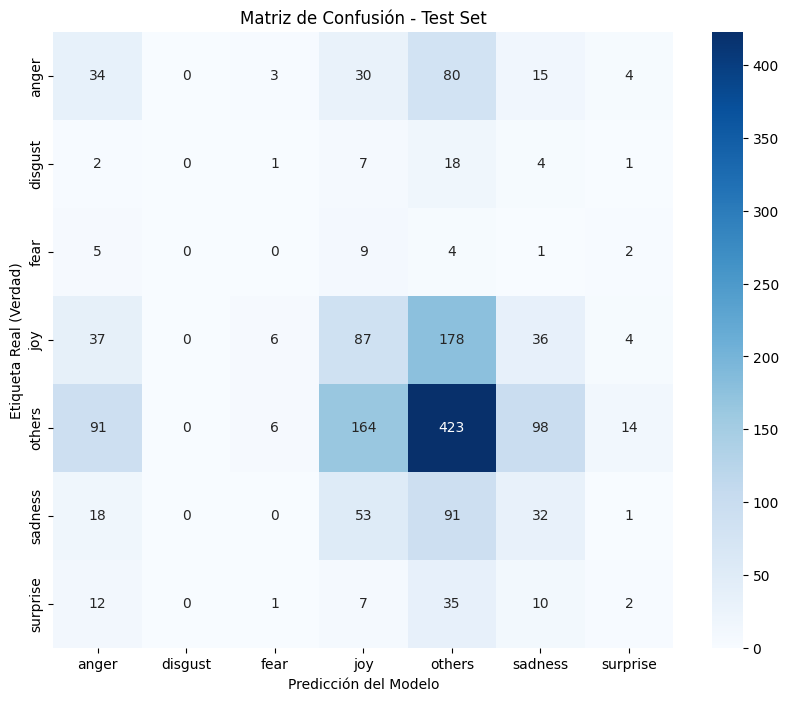

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Obtener predicciones sobre el Test Set
print("Generando predicciones sobre el Test Set...")
predictions_output = trainer.predict(encoded_dataset["test"])
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

# 2. Crear la Matriz de Confusión
cm = confusion_matrix(labels, preds)
label_names = [id2label[i] for i in range(len(id2label))]

# 3. Graficar
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.ylabel('Etiqueta Real (Verdad)')
plt.xlabel('Predicción del Modelo')
plt.title('Matriz de Confusión - Test Set')
plt.show()

In [12]:
from transformers import pipeline

# 1. Pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

def probar_frase(texto):
    prediction = classifier(texto)[0]
    
    # --- CORRECCIÓN ---
    # Tu modelo ya devuelve el nombre real (ej: 'anger'), no hace falta convertir números.
    etiqueta = prediction['label'] 
    score = prediction['score']
    
    # Traducimos al español visualmente para que quede más bonito
    return f"🗣️: '{texto}' \n   --> 🤖: {etiqueta.upper()} ({score:.1%})\n"

print("--- RESULTADOS EN VIVO (AHORA SÍ) ---")
print(probar_frase("¡Estoy harto de que siempre llegues tarde!"))      
print(probar_frase("Qué felicidad, por fin terminamos el proyecto."))    
print(probar_frase("Tengo miedo de caminar solo por esa calle."))        
print(probar_frase("Me da asco la comida que sirvieron hoy."))           
print(probar_frase("Es una pena que no hayas podido venir."))


Device set to use cuda:0


--- RESULTADOS EN VIVO (AHORA SÍ) ---
🗣️: '¡Estoy harto de que siempre llegues tarde!' 
   --> 🤖: ANGER (35.8%)

🗣️: 'Qué felicidad, por fin terminamos el proyecto.' 
   --> 🤖: JOY (95.7%)

🗣️: 'Tengo miedo de caminar solo por esa calle.' 
   --> 🤖: FEAR (76.9%)

🗣️: 'Me da asco la comida que sirvieron hoy.' 
   --> 🤖: ANGER (64.7%)

🗣️: 'Es una pena que no hayas podido venir.' 
   --> 🤖: SADNESS (97.8%)



In [13]:
# 1. Guardar el modelo y el tokenizador en una carpeta
save_directory = "./modelo_emociones_beto"

# Guardamos tanto el modelo (pesos) como el tokenizador (vocabulario)
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"✅ Modelo guardado en {save_directory}")

import shutil
shutil.make_archive("mi_modelo_beto", 'zip', save_directory)
print("📦 Archivo 'mi_modelo_beto.zip' creado. ¡Descárgalo desde la barra lateral de archivos!")

✅ Modelo guardado en ./modelo_emociones_beto
📦 Archivo 'mi_modelo_beto.zip' creado. ¡Descárgalo desde la barra lateral de archivos!
